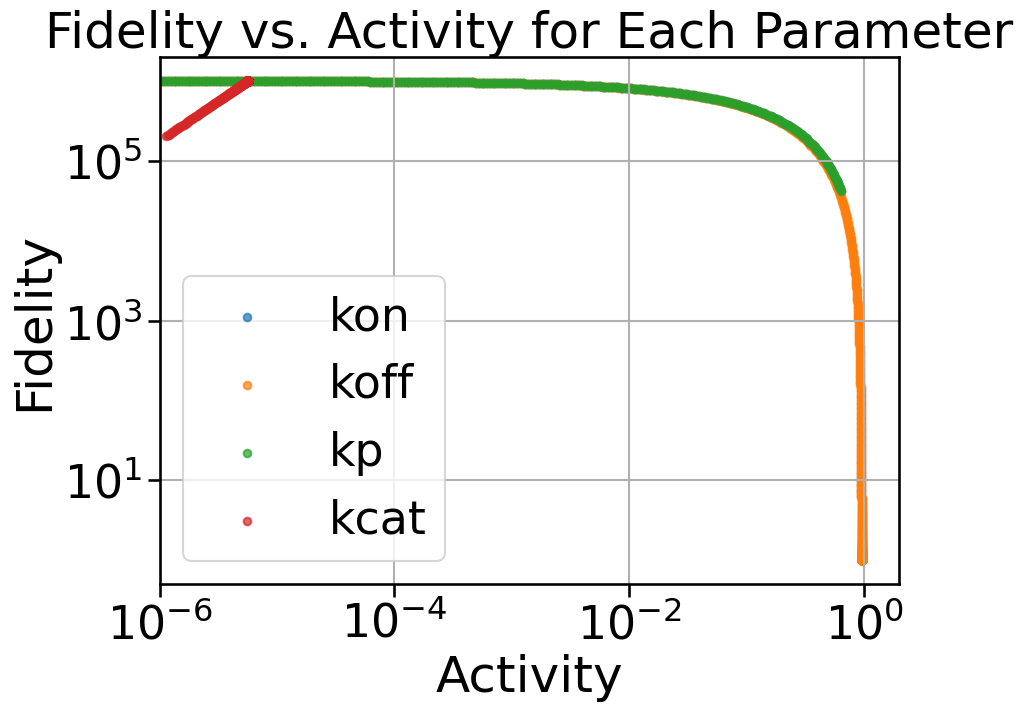

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import comb

def tradeoff_reaction_expression_n(kvec, koff_r2w, n):
    kon, koff, kp, kcat = kvec
    koffw = koff * koff_r2w

    # Part 1: (k_off + k_p)^n and (k_offw + k_p)^n
    part1_R = (koff + kp)**n
    part1_W = (koffw + kp)**n

    # Part 2: k_on multiplied by the sum of terms
    sum_terms_r = 0
    for i in range(n):
        coefficient = comb(n-1, i) * (i + 1)
        term = coefficient * koff**(n-1 - i) * kp**i
        sum_terms_r += term
    
    # For W, use koffw instead of koff
    sum_terms_w = 0
    for i in range(n):
        coefficient = comb(n-1, i) * (i + 1)
        term = coefficient * koffw**(n-1 - i) * kp**i
        sum_terms_w += term
    
    part2_R = kon * sum_terms_r
    part2_W = kon * sum_terms_w

    # Compute activity
    denominator_R = (koff + kon) * (koff + kp)**n + kcat * (part1_R + part2_R)
    activity = kon * kp**n / denominator_R

    # Compute fidelity
    numerator_W = (koffw + kon) * (koffw + kp)**n + kcat * (part1_W + part2_W)
    fidelity = numerator_W / denominator_R

    return activity, fidelity

# Parameters for sensitivity analysis
n_pts = 1000  # Number of points for each parameter variation
min_log10 = -6
max_log10 = 6
koff_r2w = 1e3  # koffw = koff * koff_r2w
n = 1  # Fixed n for the reaction

# Baseline parameter values (log-uniform sampling for a single point)
np.random.seed(42)  # For reproducibility
baseline = 10**(np.random.rand(4) * (max_log10 - min_log10) + min_log10)
baseline[0] = baseline[2]  # Ensure kon = kp

# Parameter names
param_names = ['kon', 'koff', 'kp', 'kcat']

# Range for varying parameters
param_range = np.logspace(min_log10, max_log10, n_pts)

# Store results for activity and fidelity
results = {
    'Activity': np.zeros((4, n_pts)),  # 4 params, n_pts variations
    'Fidelity': np.zeros((4, n_pts))
}

# Sensitivity analysis
for param_idx, param_name in enumerate(param_names):
    for i, param_value in enumerate(param_range):
        # Copy baseline parameters
        kvec = baseline.copy()
        
        # Vary the parameter of interest
        if param_name == 'kon':
            kvec[0] = param_value
            kvec[2] = param_value  # Ensure kon = kp
        elif param_name == 'koff':
            kvec[1] = param_value
        elif param_name == 'kp':
            kvec[2] = param_value
            kvec[0] = param_value  # Ensure kon = kp
        elif param_name == 'kcat':
            kvec[3] = param_value
        
        # Compute outputs
        activity, fidelity = tradeoff_reaction_expression_n(kvec, koff_r2w, n)
        
        # Store results
        results['Activity'][param_idx, i] = activity
        results['Fidelity'][param_idx, i] = fidelity

# Plotting the relationship between fidelity and activity
plt.figure(figsize=(10, 8))
for param_idx, param_name in enumerate(param_names):
    plt.scatter(results['Activity'][param_idx], results['Fidelity'][param_idx], label=param_name, s=30, alpha=0.7)

plt.xscale('log')
plt.yscale('log')
plt.xlim([1e-6,1*2])
#plt.ylim([1,1e6*2])
plt.xlabel('Activity')
plt.ylabel('Fidelity')
plt.title('Fidelity vs. Activity for Each Parameter')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save the plot
#plt.savefig('fidelity_vs_activity.png')
plt.show()
plt.close()

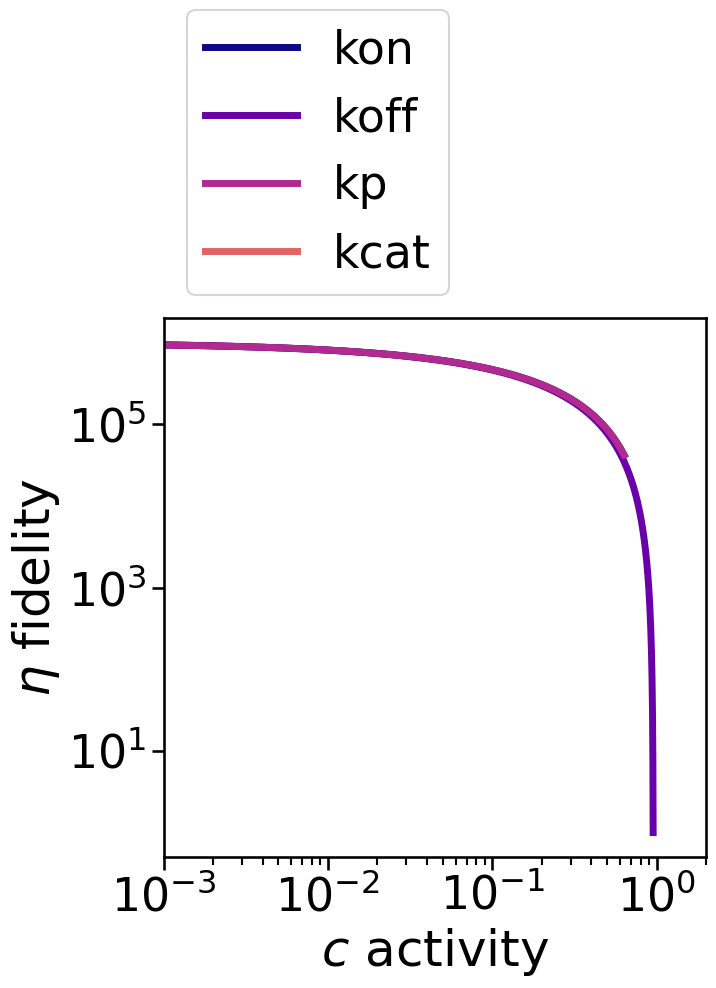

In [16]:
# Set up the plot with specified style
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
sns.set_context('talk', font_scale=2, rc={'lines.linewidth': 3})

# Define colors
colors = ['#0d0887', '#6a00a8', '#b12a90', '#e16462', '#f0f921']

# Plot fidelity vs. activity for each parameter
for param_idx, param_name in enumerate(param_names):
    # Sort by parameter value for smooth lines
    idx = np.argsort(param_range)
    ax.plot(results['Activity'][param_idx][idx], results['Fidelity'][param_idx][idx], 
            lw=5, color=colors[param_idx % len(colors)], 
            label=r'{}'.format(param_name))

ax.set_xlabel(r'$c$ activity')
ax.set_ylabel(r'$\eta$ fidelity')
plt.xlim([1e-3,1*2])
#plt.ylim([1,1e6*2])
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(bbox_to_anchor=(0, 1), loc='lower left')
plt.savefig('fidelity_vs_activity.svg', bbox_inches='tight', transparent=True)
plt.show()
plt.close()